Determine whether male and female listeners are significantly different in their overall listening (in terms of the count of track listens, or in terms of the total time spent listening)




In [1]:
from __future__ import division
import sys, os
import numpy as np
import pandas as pd
import time
from scipy.stats import chisquare, chi2_contingency
from helpers import *
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams.update({'font.size': 16})

In [2]:
df_user = pd.read_csv('data_sample/user_data_sample.csv')
df_song = pd.read_csv('data_sample/end_song_sample.csv')
df = pd.merge(df_user, df_song, on='user_id',  how='left')

----
### Popularity of Tracks

Firstly, look at some statistical descriptions of the data regarding track lenghts, count of track listens, proportion of skipped tracks vs full listens, etc...




In [3]:
# Define 'skipped track' those with ms_played < 10 sec.
skip_cutoff = 10 * 1e3
grouped_all = df.groupby('track_id')
grouped_nonskipped = df[df['ms_played'] >= skip_cutoff].groupby('track_id')
grouped_skipped = df[df['ms_played'] < skip_cutoff].groupby('track_id')

print len(grouped_nonskipped)
print len(grouped_skipped)
print len(grouped_all)
print df.shape

252321
144293
314985
(1342891, 10)


Total num of records = 1342891  
Total no of distinct tracks = 314985

In [4]:
def plotter(xlabel=None, ylabel=None, title=None, xlim=None, ylim=None):
    fig = plt.figure()
    ax = plt.gca()
    fig.set_size_inches((15,5))
    plt.grid('on')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim: plt.xlim((0, xlim));
    if ylim: plt.xlim((0, ylim));
    plt.title(title)
    return fig, ax
    
    

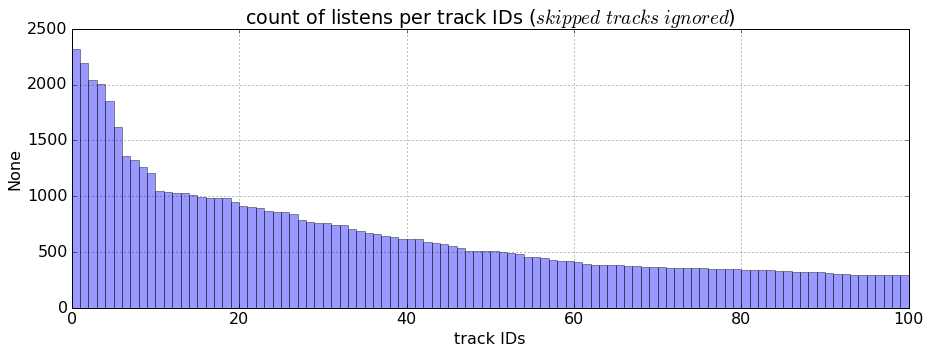

In [5]:
dict_track= grouped_nonskipped.groups
track_id = dict_track.keys()
track_count = map(lambda x: len(x), dict_track.values())
a = sorted(zip(track_id, track_count), key=lambda x: x[1], reverse=True)
track_id, track_count = zip(*a)

# ----------------------------------------------------------------

xlim = 100 # choose first 100 songs to display
fig, ax = plotter(xlabel='track IDs', xlim=xlim, \
                 title='count of listens per track IDs ($\itskipped\ tracks\ ignored$)')

ax.bar(range(len(track_id[:xlim])), track_count[:xlim], color= 'b', width=1.0, alpha=0.4);

In [9]:
def num_of_listens(df):
    dict_track= df.groupby('track_id').groups
    grouped = df.groupby('track_id')
    s = grouped.apply(lambda x: sum(x['ms_played'] >= skip_cutoff))
    """ s is a pd.Series with index: 'track_ID' and 
     values: 'count of records that match the above condition'. 
     value == 0 means the track was never listened to for more than skip_cutoff secs"""

    s_arr = np.array(s)
    num_of_interest = s_arr[s_arr > 1].shape[0]
    # print 'Question: What percentage of tracks have been listened to for one or more times?'
    print 'Answer: {}%'.format(round(num_of_interest / len(s_arr) * 100))
    return s_arr

In [10]:
# THIS CELL TAKES A COUPLE MINS TO RUN
t0 = time.time()
grouped = df.groupby('gender')
# 'unknown' gender is omitted from calculations
male = grouped.get_group('male')
female = grouped.get_group('female')
unknown = grouped.get_group('unknown')
s1 = num_of_listens(df)
s2 = num_of_listens(male)
s3 = num_of_listens(female)
s3 = num_of_listens(unknown)
print round(time.time() - t0), 'secs' 

Answer: 33.0%
Answer: 31.0%
Answer: 33.0%
Answer: 22.0%
122.0 secs


In [11]:
print ' percentage of tracks were skipped: {}% (all)'.format(round(len(s1[s1==0]) / len(s1)*100))
print ' percentage of tracks were skipped: {}% (male)'.format(round(len(s2[s2==0]) / len(s2)*100))
print ' percentage of tracks were skipped: {}% (female)'.format(round(len(s3[s3==0]) / len(s3)*100))

 percentage of tracks were skipped: 20.0% (all)
 percentage of tracks were skipped: 20.0% (male)
 percentage of tracks were skipped: 16.0% (female)


Total num of records = 1342891  
Total no of distinct tracks = 314985

* Question: What percentage of tracks have been listened to for more than only once?  .... 33 %  
(and there's no significant gender variation (male: 31 %, female: 33 % ))  


* Question: What percentage of tracks were skipped?  .... 20 %  
(again there's no significant gender variation (male: 20 %, female: 21 % ))


In [12]:
unk = grouped.get_group('unknown')
skip_a =      np.sum([df['ms_played'] < skip_cutoff])/len(df) * 100
skip_m =    np.sum([male['ms_played'] < skip_cutoff])/len(male) * 100
skip_f =  np.sum([female['ms_played'] < skip_cutoff])/len(female) * 100
skip_u =     np.sum([unk['ms_played'] < skip_cutoff])/len(unk) * 100
print " all gender [0-10] sec percentage = {} %".format(round(skip_a))
print "       male [0-10] sec percentage = {} %".format(round(skip_m))
print "     female [0-10] sec percentage = {} %".format(round(skip_f))
print "    unknown [0-10] sec percentage = {} %".format(round(skip_u))

 all gender [0-10] sec percentage = 33.0 %
       male [0-10] sec percentage = 33.0 %
     female [0-10] sec percentage = 33.0 %
    unknown [0-10] sec percentage = 24.0 %


* Question: What percentage of the records have been due to skipping the tracks?  .... 33 %  
(there's no significant gender variation (male: 33 %, female: 33 % ))  

 len(unk) == 2234  
 len(male) == 691479  
 len(female) == 649178


----
### Regularity of Users

Question: What are the gender demographics?  
> total num of users = 9565  
male = 4979  
female = 4560  
unknown gender = 26  


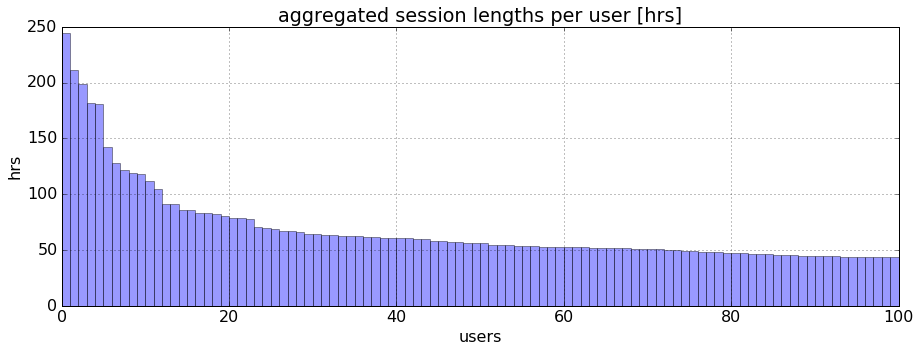

In [13]:
users = df.groupby('user_id')
total_usage = users.apply(lambda x: np.sum(x['ms_played']))
total_usage.sort_values(inplace=True, ascending=False)
user_id = total_usage.index

# ----------------------------
_, ax = plotter(xlim=100, xlabel='users', ylabel='hrs', \
                title='aggregated session lengths per user [hrs]')

plt.gca().bar(range(len(user_id))[:100], np.array(total_usage)[:100]/1000/60/60, width=1.0, color='b', alpha=.4);

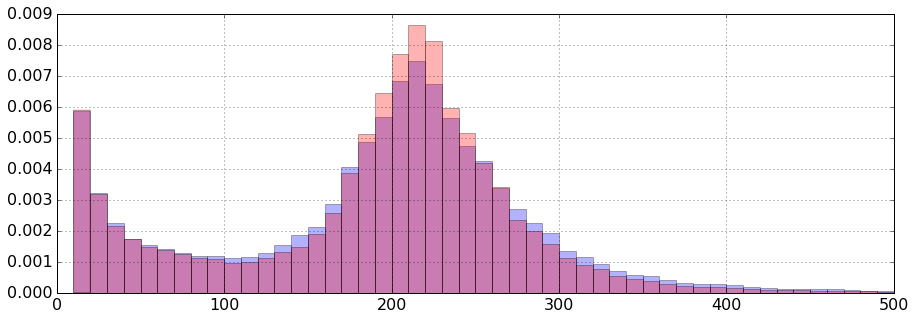

In [14]:
width = 10
# Impose and use same bin ranges for male and female hist()
# ignore the [0-10] sec quick-skip range
bin_range = np.linspace(10,500,(500/width))
# convert ms to secs
secs_played_m = male['ms_played']/1000.
secs_played_f = female['ms_played']/1000.

_, ax = plotter(xlim=500, xlabel='secs played',
                title='histogram for track listen times ($\itskipped\ tracks\ omitted$)')

ax.legend(['male','female'])
n_m, _, _ = plt.hist(secs_played_m, bins=bin_range, width=width, alpha=0.3, color='b')
n_f, _, _ = plt.hist(secs_played_f, bins=bin_range, width=width, alpha=0.3, color='r')
# n_m & n_f are total track listening times for male and female.
# They're going to be used for chi2 test later. 
# The histograms are plotted for normalized frequencies.
ax.cla()
ax.grid('on')
plt.hist(secs_played_m, bins=bin_range, width=width, alpha=0.3, color='b', normed=True);
plt.hist(secs_played_f, bins=bin_range, width=width, alpha=0.3, color='r', normed=True);

**Comments:**  
* The normalized histograms, exhibit a higher kurtosis for *female track listen times* than its male counterpart -- the frequency between [180 - 240] sec range is higher for females.  
For a more robust analysis, $\chi^2$-test for independence will be employed.   



* The histogram looks like a superposition of a _Gaussian Distribution_ and an *Exponential-like Distribution*:
The Gaussian Distribution seems to reflect the distibution of track lengths where the user listened to the whole track.  
The Exponential Distribution likely originates from the listeners skipping songs. In this case, the random variable would be defined as the part of the song played before it was skipped. The distribution might deviate from the analytical exponential distribution profile leaning more heavily on the smaller values.


------------------

### $\chi^2$-test for independence for track listening time across genders
The question being considered is whether the *total track listening time* varies across `male` and `female` listeners.  

$H_o$: *Total track listening time*  doesn't vary across `male` and `female` listeners. (`male` and `female` have same pdfs)

In [15]:
# my_chisquare_p_value(n_m, n_f)
_, p_value, _, _ = chi2_contingency(np.vstack((n_m,n_f)))
print p_value

0.0


Conclusion:  
* Reject $H_o$!...   
* Consumer listening habits vary across the genders.

---------

### $\chi^2$-test for independence for age groups across genders
Question: Does the *total track listening time* vary across `male` and `female` listeners? 

$H_o$: *Total track listening time*  is independent of gender of listeners. (`male` and `female` listeners have same pdfs)

In [16]:
# omit the [0-10] sec range

grouped_m = male[male['ms_played'] > skip_cutoff].groupby('age_range')
grouped_f = female[female['ms_played'] > skip_cutoff].groupby('age_range')
age_m = grouped_m.groups.keys()
age_f = grouped_f.groups.keys()
grouped_m.sum()

,acct_age_weeks,ms_played,end_timestamp
age_range,,,
0 - 17,1768276,6776433259,5.659032e+13
18 - 24,10917207,27085853778,2.116683e+14
25 - 29,8060564,18829213400,1.401446e+14
30 - 34,7103702,12994066936,9.353675e+13
35 - 44,5426976,12131872877,8.578032e+13
45 - 54,2844642,6073658272,4.366900e+13
55+,2482878,4647445753,3.433359e+13


In [17]:
male_hrs = grouped_m.sum()['ms_played']/1000./60./60.
female_hrs = grouped_f.sum()['ms_played']/1000./60./60.
print "total no of male listeners: ", df[df['gender']=='male'].shape[0] # 691479
print "total no of female listeners: ", df[df['gender']=='female'].shape[0] # 649178
male_hrs

total no of male listeners:  691479
total no of female listeners:  649178


age_range
0 - 17     1882.342572
18 - 24    7523.848272
25 - 29    5230.337056
30 - 34    3609.463038
35 - 44    3369.964688
45 - 54    1687.127298
55+        1290.957154
Name: ms_played, dtype: float64

number of male and female listeners are more or less comparable. 

In [18]:
def autolabel(rects, ax, draw=False):
    """
    Attach a text label above each bar displaying its height
    """
    
    heights = []
    for rect in rects:
        heights.append(rect.get_height())

    percent = [float(h)/sum(heights)*100.0 for h in heights]
    
    e1, e2 = plt.ylim()
    plt.ylim((e1, e2*1.09))
    
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if draw:
            ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, \
                '%d' % round(percent[i]) + '%', \
                ha='center', va='bottom')
        
    return percent

[7.653653348932926, 30.592160736087504, 21.266685096511885, 14.676169619008569, 13.702363164362069, 6.859903019339539, 5.249065015757511]
[14.557944055964963, 36.14748491344036, 16.456071876239584, 11.59516263194067, 12.874597479330207, 5.751169594633451, 2.6175694484507463]


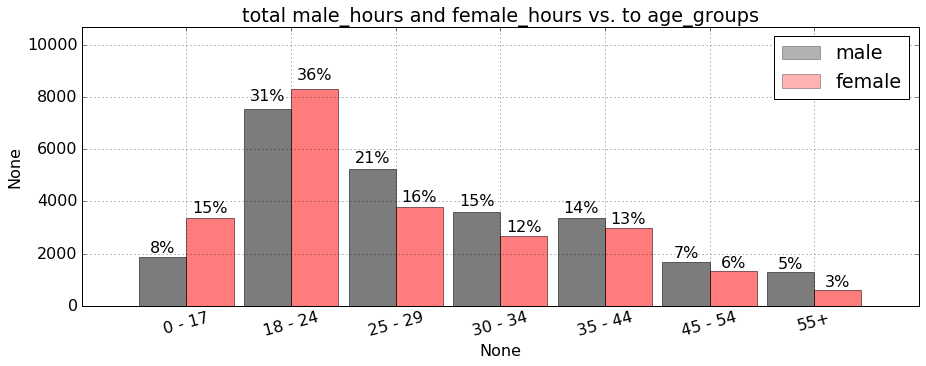

In [19]:
my_xticks = sorted(age_m)
ind = np.asarray(range(len(np.asarray(male_hrs))))
width = .45

_, ax = plotter(title='total male_hours and female_hours vs. to age_groups')
ax.bar(ind - width, np.asarray(male_hrs), width=width, color='k', alpha=.3)
ax.bar(ind,         np.asarray(female_hrs), width=width, color='r', alpha=.3)


rects1 = ax.bar(ind - width, np.asarray(male_hrs), width=width, color='k', alpha=.3)
rects2 = ax.bar(ind,         np.asarray(female_hrs), width=width, color='r', alpha=.3)

percent1 = autolabel(rects1, ax=ax, draw=True)
percent2 = autolabel(rects2, ax=ax, draw=True)
print percent1
print percent2
plt.xticks(ind, my_xticks, rotation=15)
ax.legend(['male','female']);

The aggregate usage is much higher for the age group [18 - 24] for both male (30%) and female (36%)

In [20]:
_, p_value, _, _ = chi2_contingency(np.vstack((male_hrs,female_hrs)))
print p_value

1.03219052416e-232


* According to the $\chi^2$-test p-value, Spotify usage frequency of male and female listeners have different probability distributions.  

* Female listeners of age 24 or less are responisble for 50 % of all  usage in their gender group.
However, male listeners who are of age 24 years or less are responsible for only 37 % of male listening hours.

---
Comments: A bar plot with `track_id`s on the x-axis, and `total track play time` on the y-axis with respect to `gender` or `country` would help show the differences in user behavior.

---
### Break DataFrame Into Sessions
 
> * group `df` by `user_id`,   
> * sort `df` wrt column `end_timestamp`,   
> * create a new column `end_time_diff` that carries the value of end_time difference between two successive listening events.


### try new alternative to building df_new

In [21]:
# ### try new alternative to building df_new
# # This routine takes 10 mins to run. 
# # Instead, try building from the 9565 user groups and 
# # writing them to a csv file to read and concatenate 
# # them to df_new.

# t0 = time.time()
# df['end_timestamp'] += -min(df['end_timestamp'])

# grouped = df.groupby('user_id')
# user_ids = grouped.groups.keys()  # len(user_ids) = 9565
# df['labels'] = 0
# df['end_time_diff'] = 0.0
# # build a new df from individual 'user_id' groups.
# # write a 'df_new/df_new{}.csv' and then reset df_new every 1000 user iterations
# m = 0
# for i, key in enumerate(user_ids[:]):
#     sys.stdout.flush()
#     print i,"      \r",
#     user = df[df['user_id'] == key].sort_values('end_timestamp')
#     user['end_time_diff'] = (user['end_timestamp'] - user['end_timestamp'].shift(1)).fillna(-1)
#     delta = user.shape[0]
#     ind_label = range(m, m+delta)
#     df.loc[ind_label,'labels'] = user.index
#     df.loc[user.index, 'end_time_diff'] = user['end_time_diff']
#     m += delta
# print (time.time() - t0) / 60
# df_new = df.loc[df['labels']]

# df_new = df_new.reset_index(drop=True)
# df_new.drop('labels', axis=1, inplace=True)
# df_new.head()


In [22]:
# # THIS CELL TAKES 10 MINS TO RUN!!!
# # But it only has to be run once to produce complementary segments 
# # of 'df_new' into .csv files
# #
# # It first groups df by 'user_id',
# #    then sorts each group by 'end_timestamp',
# #    then concatenates the groups into a dataframe, 1000 groups at a time
# #    then writes the dataframe to a df_new/[filename].csv
# #    until it exhausts all the groups.
# #
# # Run this cell once to write the output into df_new/*.csv
# # Then load with pd.read_csv()

# t0 = time.time()
# df['end_timestamp'] += -min(df['end_timestamp'])

# grouped = df.groupby('user_id')
# user_ids = grouped.groups.keys()  # len(user_ids) = 9565
# df_new = pd.DataFrame()

# # build a new df from individual 'user_id' groups.
# # write a 'df_new/df_new{}.csv' and then reset df_new every 1000 user iterations
# for i, key in enumerate(user_ids[:]):
#     sys.stdout.flush()
#     print i,"      \r",
#     user = grouped.get_group(key).sort_values('end_timestamp')
#     user['end_time_diff'] = (user['end_timestamp'] - user['end_timestamp'].shift(1)).fillna(-1)
#     df_new = pd.concat([df_new, user])
    
#     if ((i % 500 == 0) and (i != 0)) or (i == len(user_ids)-1):
#         df_new.to_csv('df_new/df_new{}.csv'.format(i))
#         df_new = pd.DataFrame()

# print round(time.time() - t0), 'secs' 

In [23]:
def sorted_ls(dirpath):
    mtime = lambda f: os.stat(os.path.join(dirpath, f)).st_mtime
    return list(sorted(os.listdir(dirpath), key=mtime))

In [24]:
# load pre-generated segments of 'df_new' from 
# df_new/*.csv files and concatenate them.

ls = sorted_ls('df_new')
df_new = pd.DataFrame()
ls = [fn for fn in ls if fn[-3:] == 'csv']

for csv in ls:
    df_load = pd.read_csv(os.path.join('df_new', csv))
    df_new = pd.concat([df_new, df_load])


In [25]:
if 'Unnamed: 0' in df_new.columns:
    print 'dropping Unnamed: 0'
    df_new.drop('Unnamed: 0', axis=1, inplace=True)
    
if 'labels' in df_new.columns:
    print 'dropping labels'
    df_new.drop('labels', axis=1, inplace=True)
    
df_new = df_new.reset_index(drop=True)
# print df_new.shape
# print df.shape

# print df_new.columns
# print df.columns



dropping Unnamed: 0


>   Define a "session start event" if more than 15 mins has elapsed since last track has been played. 

In [26]:
# THIS CELL TAKES 1 MIN TO RUN.
# define end of a session if more than 15 minute elapses between track listen events
t0 = time.time() 
sess_break_cutoff = 15*60  # in secs
df_new['session'] = df_new.apply(lambda row: 'start' \
         if (row['end_time_diff'] - row['ms_played']/1000 > sess_break_cutoff) \
         or (row['end_time_diff'] == -1.00) \
         else '.', axis=1)
print round(time.time() - t0), 'secs'

55.0 secs


In [27]:
df_new.tail(3)

,gender,age_range,country,acct_age_weeks,user_id,ms_played,context,track_id,product,end_timestamp,end_time_diff,session
1342888,female,0 - 17,US,3,9904736e114444e099d66dc57a849b29,1532,playlist,99879680b0474e8e87460d05745aec27,open,803431.18,38486.04,start
1342889,female,0 - 17,US,3,9904736e114444e099d66dc57a849b29,1532,playlist,99879680b0474e8e87460d05745aec27,open,892609.71,89178.53,start
1342890,female,0 - 17,US,3,9904736e114444e099d66dc57a849b29,1532,playlist,99879680b0474e8e87460d05745aec27,open,1112942.10,220332.39,start


In [28]:
session_start_indices = df_new[df_new['session'] == 'start'].index
session_end_indices = (session_start_indices[1:] - 1).append(pd.Int64Index([df_new.index.max()]))

df_s1 = df_new.loc[session_start_indices]['end_timestamp']
df_s2 = df_new.loc[session_end_indices]['end_timestamp'] 
df_s3 = df_new.loc[session_start_indices]['ms_played']/1000

# Redefine the index labels so we can do algebra on dataframes
df_s2.index = session_start_indices
df_s3.index = session_start_indices

# create a new column for 'session_length' in [sec]
df_new['session_length'] = df_s2 - df_s1 + df_s3

In [29]:
# notice that context can change within the same session 
df_new[0:3][['end_timestamp', 'end_time_diff', 'ms_played', 'product',\
              'user_id', 'session', 'session_length']]

,end_timestamp,end_time_diff,ms_played,product,user_id,session,session_length
0,830421.85,-1.00,68759,open,a0cf7721e54d4cbeb5f08cf4137ce322,start,192.029
1,830535.52,113.67,98469,open,a0cf7721e54d4cbeb5f08cf4137ce322,.,NaN
2,830541.19,5.67,8767,open,a0cf7721e54d4cbeb5f08cf4137ce322,.,NaN


In [30]:
e1 = df_new['ms_played']/1000 < df_new['end_time_diff'] 
e2 = df_new['session'] == 'start'
e1, e2 = pd.DataFrame(e1), pd.DataFrame(e2)
e1['label'] = np.array(e1.index)
e2['label'] = np.array(e2.index)

e = pd.merge(e1, e2, on='label')
e['and'] = e.apply(lambda row: row[0] or row['session'], axis=1)
e['and'].sum() / 1342891 * 100

64.170137412492906

A Curious Finding:  
> According to the records, in 35% of them the `ms_played` is larger the end_time_difference between two sucessive track listening events!!! And in 1.4% of them,  `ms_played` is more than 3 seconds longer than then end_time_difference. 

* `df_new` carries the '`session`' and `'session_length'` columns

---


### Average Session Lengths

Questions to be explored:
1. Does the avg session length vary with respect to `'country'`?
2. Does the avg session length vary with respect to `'gender'`?
3. Does the avg session length vary with respect to `'context'`?
4. Does the avg session length vary with respect to `'product'` (paid or free)?
5. Does the avg session length vary with respect to `'age_range'`?


In [181]:
# Double check the rest of the routine
# and elaborate your report, future work and analysis.

In [32]:
num_track_per_session = np.array(session_end_indices - session_start_indices + 1)
print 'Average num of tracks per session: {}'.format(np.mean(num_track_per_session))

maxind = session_start_indices[np.argmax(num_track_per_session)]

# df_new.loc[maxind-5:maxind+10]

Average num of tracks per session: 12.3168239643


> * Average num of tracks per session = 12  
> * Max num of tracks played in a single session = 1897 (This also coincides with the longest session w/ `session_length` = 118 hrs 35 min, `'product' = 'open'`)


In [157]:
def bar_plot_session_length(column_name='country', rotation=0, sort=True,\
                            mean_or_sum='mean', width=.9, pct_label=False):
    # this function first groups by the "column_name"
    #               then calculates "sum" and "mean" of sessions lengths wrt 'country' column
    #               then ax.bar plot it.
    
    df_sessions = df_new[df_new['session'] == 'start']
    grouped = df_sessions['session_length'].groupby(df_new[column_name])
    g_sum  = grouped.apply(lambda x: np.sum(x)/60) # convert to [min]
    g_mean = grouped.apply(lambda x: np.mean(x)/60)
    g_names = list(g_sum.index) # returns alphabetical ordered list of group names
    
    if sort:
        g_sum.sort_values(ascending=False, inplace=True)
        g_mean.sort_values(ascending=False, inplace=True)
    
    g_names = list(g_sum.index) # returns alphabetical ordered list of group names    
    
    y = g_mean if mean_or_sum == 'mean' else g_sum

    plt.figure().set_size_inches((15, 5))
    ax = plt.gca()
    
    x = np.array(range(len(y)))
    rects = ax.bar(x+.5-width/2, y, color='b', width=width, alpha=.4)
    
    if pct_label:
        percent1 = autolabel(rects, ax=ax, draw=True)

    plt.xticks(x+.5, g_names, rotation=rotation)
    plt.ylabel('[min]')
    plt.grid('on')
    plt.xlim([0, max(x)+1])
    tit_bit = 'average' if mean_or_sum == 'mean' else 'aggregate'
    plt.title(tit_bit + ' session lengths wrt to '+ column_name +' [min]');

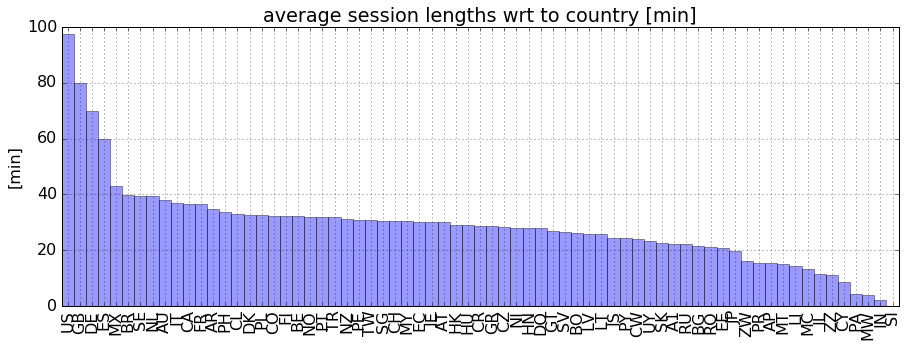

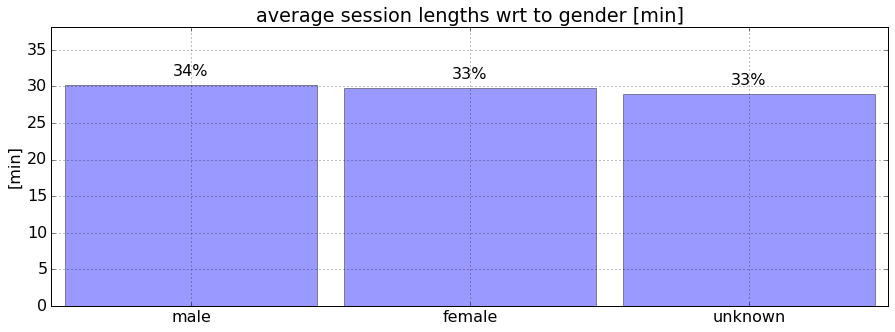

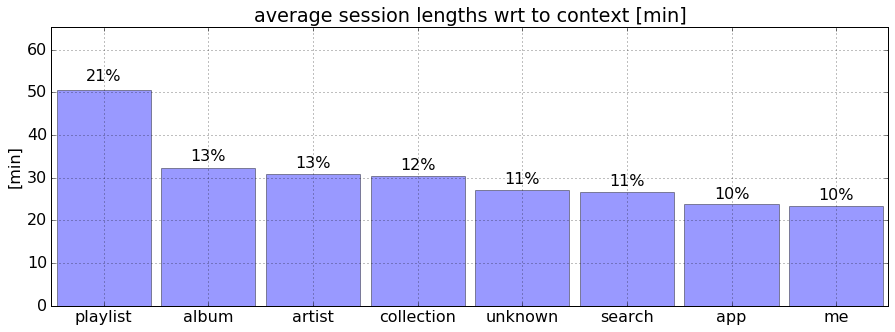

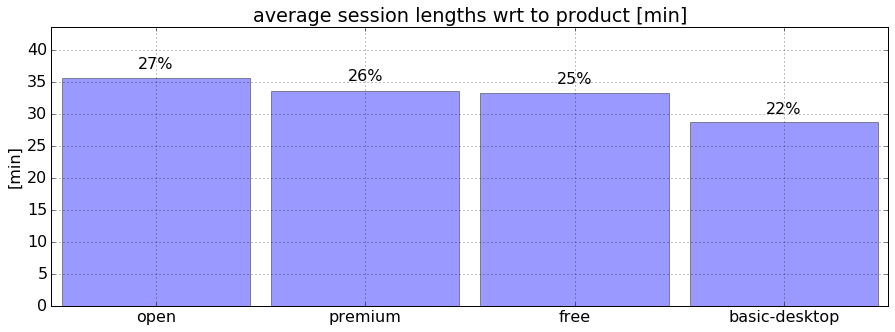

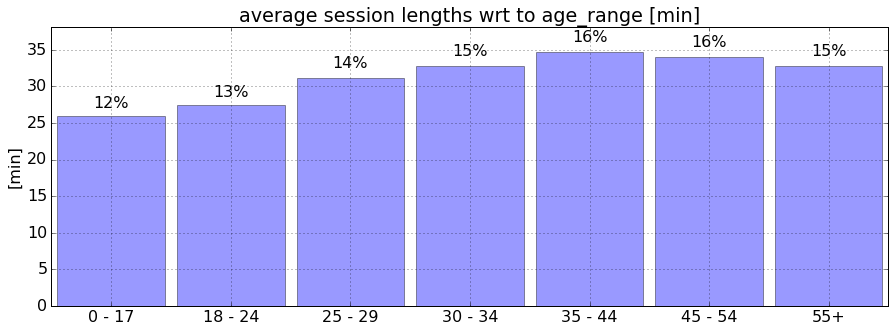

In [158]:
bar_plot_session_length(column_name='country', rotation=90, width=1)
bar_plot_session_length(column_name='gender', rotation=0, pct_label=True)
bar_plot_session_length(column_name='context', rotation=0, pct_label=True)
bar_plot_session_length(column_name='product', pct_label=True)
bar_plot_session_length(column_name='age_range', sort=False, pct_label=True)

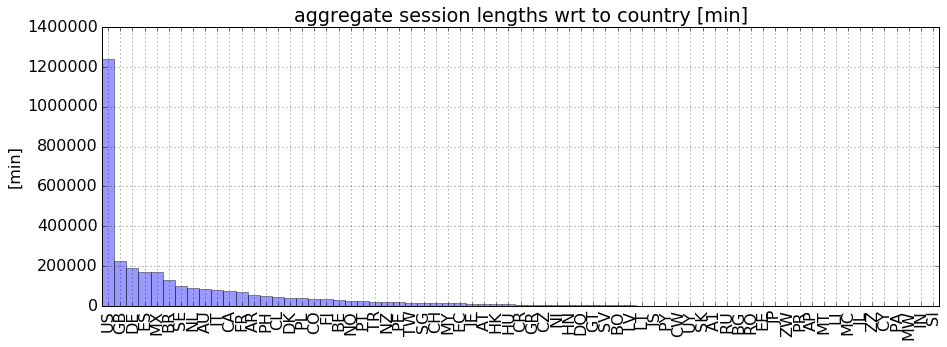

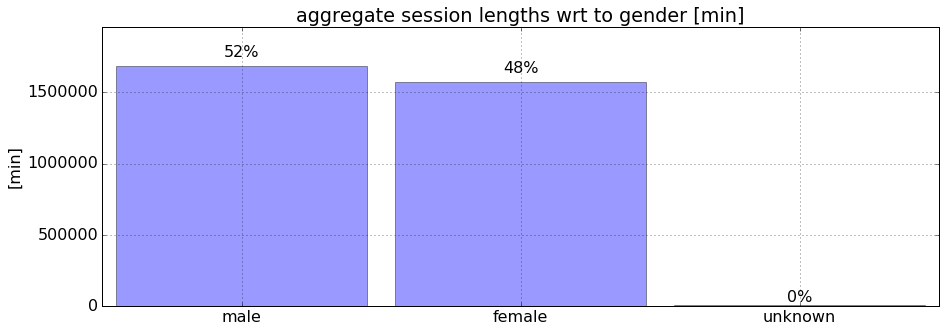

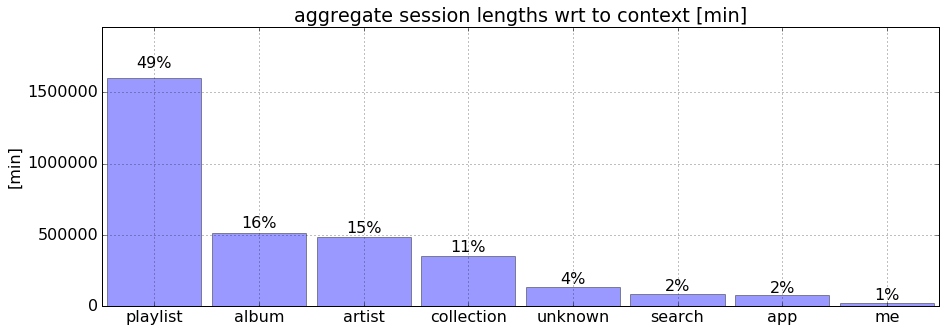

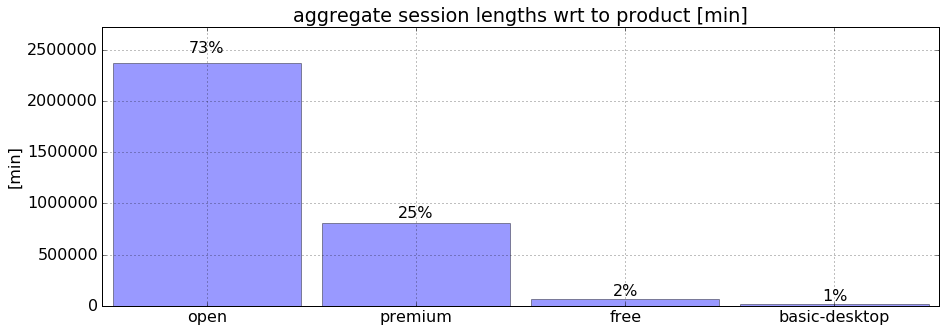

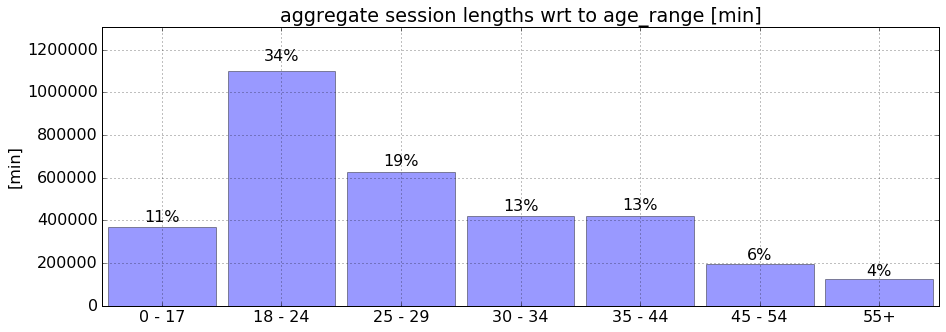

In [159]:
bar_plot_session_length(column_name='country', rotation=90, mean_or_sum='sum', width=1)
bar_plot_session_length(column_name='gender', rotation=0, mean_or_sum='sum', pct_label=True)
bar_plot_session_length(column_name='context', rotation=0, mean_or_sum='sum', pct_label=True)
bar_plot_session_length(column_name='product', mean_or_sum='sum', pct_label=True)
bar_plot_session_length(column_name='age_range', sort=False, mean_or_sum='sum', pct_label=True)

note to self:  
1. in the above plot the xticks must be shuffled out of order
2.  Since session length is an indicator for user engagement, must plot session length vs context and product!!!

  The above plot confirms what we found earlier in the analysis that the age group [18 - 24] for both male and females scored the most male and female listening hours earlier in the analysis (respectively, 30% and 36% of all listening hours of all age groups in those gender groups). The above plot confirms the same age group to have the highest rating at aggregate session lengths.

   ### Scatter Plots To Explore User Behavior

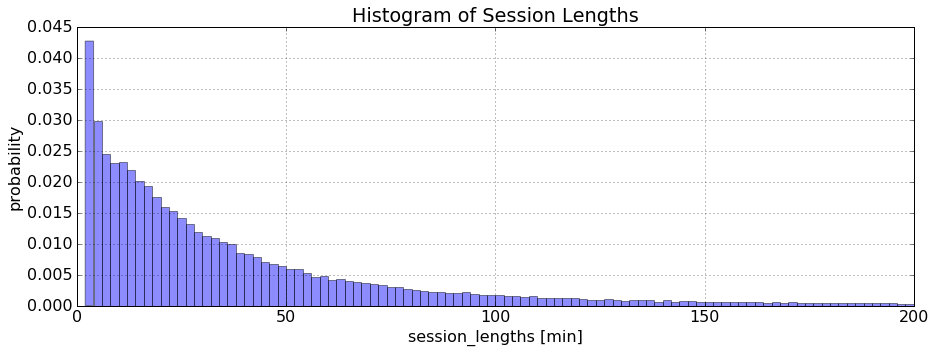

In [160]:
fig, ax = plotter(xlabel='session_length [min]', ylabel='probability',\
                  title='Histogram of Session Lengths', xlim=None, ylim=None)

df_sessions = df_new[df_new['session'] == 'start']
# filter out session_length < 2
df_sessions = df_sessions[df_sessions['session_length'] > 2*60] 
df_sessions = df_sessions[df_sessions['acct_age_weeks'] > 0] 
us = df_sessions[df_sessions['country'] == "DE"]


sessions_arr = np.array(df_sessions['session_length'])/60; #convert to [min]
sessions_arr = sessions_arr[sessions_arr > 1]
plt.hist(sessions_arr, bins=np.linspace(2,200,100), alpha=.45, normed=True);
print 


Each bin is 2 min wide. 
The histogram of `session_length`, apart form the first couple bins, resemble an Exponential Distribution. There's also an over-crowded numbers of records for session lengths in the [0-1] min range. 

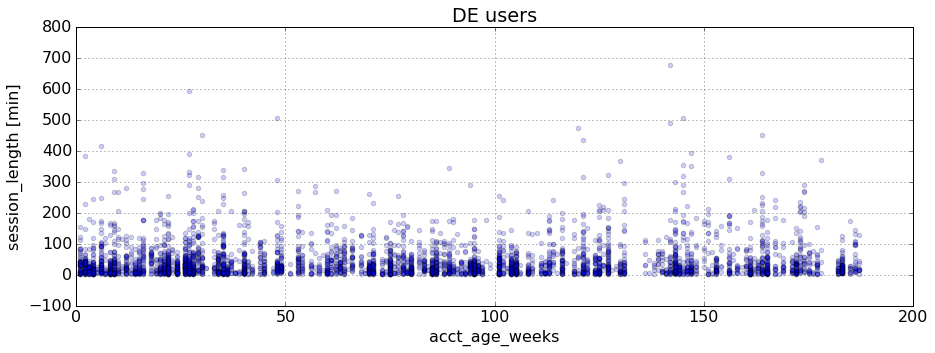

In [161]:
# Scatter plot 'acct_age_weeks' vs 'session_length'.
#
# Important columns: 'product','context','acct_age_weeks', 'country', 'gender', 'age_range'

df_sessions = df_new[df_new['session'] == 'start']
# filter out session_length < 2
df_sessions = df_sessions[df_sessions['session_length'] > 2*60] 
df_sessions = df_sessions[df_sessions['acct_age_weeks'] > 0] 
us = df_sessions[df_sessions['country'] == "DE"]
fig, ax = plotter(xlabel='acct_age_weeks', ylabel='session_length [min]',\
                  title='DE users', xlim=200,\
                  ylim=None)
plt.scatter(us['acct_age_weeks'], us['session_length']/60, alpha=.2)


> * The scatter plots of `session_length` vs `acct_age_weeks` don't signal to any correlation. 
> * There are `57` accounts with `acct_age_weeks = -1` ??
> * `26745` out of `109029` sessions have `session_length < 1.532 sec`. That's 24 % of all sessions.

In [178]:
df_new[df_new['session'] == 'start'].shape


(109029, 13)

In [179]:
26745/109029

0.24530170871969842

In [180]:
df_new.columns

Index([u'gender', u'age_range', u'country', u'acct_age_weeks', u'user_id',
       u'ms_played', u'context', u'track_id', u'product', u'end_timestamp',
       u'end_time_diff', u'session', u'session_length'],
      dtype='object')